# Explore Why Civil Resistance Works

In this notebook we will replicate and explore the findings of [Why Civil Resistance Works](https://www.ericachenoweth.com/research/wcrw) by Erica Chenoweth and Maria J. Stephan. We will work with data from the [NAVCO 1.2 Dataset](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/0UZOTX), as well as from [Polity5](https://www.systemicpeace.org/polityproject.html). Firstly, we will try and replicate the findings exploring the historical trends: frequency of violent and nonviolent campaigns, number of nonviolent campaigns and their success rate, and success rate of violent and nonviolent campaigns. Then we will examine the campaigns that had peak popular participation percentage over than 2% and investigate the campaigns in Greece. After that, we will check the effect of participation on the success of the campaign. Afterwards, we will examine the 3.5% rule, and derive our own rule in a statistical way. Finally we are going to see what happens when we create a logistic regression model considering the regime type as well.

---

> Kostas Riganas, 8200145 <br />
> Department of Management Science and Technology <br />
> Athens University of Economics and Business <br />
> t8200145@aueb.gr

First thing to do is to import the modules we will use for this notebook and get the data into their respective dataframes.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import logit

import warnings
warnings.filterwarnings('ignore')  # used because some seaborn warnings are annoying

In [2]:
navco = pd.read_csv('NAVCO 1.2 Updated.tab', sep='\t')
polity5 = pd.read_excel('p5v2018.xls')

We check how many null rows we have.

In [3]:
sum(navco.isna().sum(1) == len(navco.columns))

473

And we drop them.

In [4]:
navco.dropna(how='all', inplace=True)

## 1. Exploration of Historical Trends

### Frequency of Violent and Nonviolent Campaigns
Let's start by exploring the **historical trends**. To do that we will create new dataframes which will contain only the columns we need at each analysis. We take off with the **frequencies of violent and nonviolent campaigns**.

In [5]:
campaign_frequencies = navco.loc[:, ['EYEAR', 'NONVIOL', 'VIOL', 'SUCCESS', 'ONGOING']]

We'll make a new column that will assign a campaign to a decade. Each campaign will be assigned to the **decade preceeding** it from the end year. For example, if a campaign ended in 1954 the it will be assigned to 1950, if it ended in 2014 then in 2010, and so on and so forth.

In [6]:
decades = np.arange(1940, 2021, 10)  # ending with 2021 to get decade 2010-2020
assigned_period = pd.cut(campaign_frequencies['EYEAR'], decades, include_lowest=True, right=False)
campaign_frequencies['decade'] = assigned_period.map(lambda x: x.left)

After finding the decade each campaign belongs to, we'll group by the decade and calculate the number of violent and nonviolent campaigns, before drawing the plot.

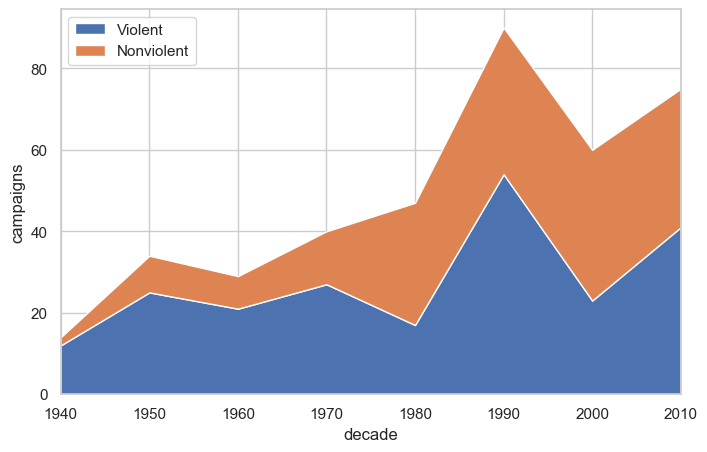

In [7]:
campaign_frequencies_by_decade = campaign_frequencies.groupby('decade', observed=False).agg(violent=('VIOL', 'sum'), nonviolent=('NONVIOL', 'sum'))

sns.set_theme()
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(8, 5))
ax.stackplot(campaign_frequencies_by_decade.index, campaign_frequencies_by_decade['violent'], campaign_frequencies_by_decade['nonviolent'], labels=['Violent', 'Nonviolent'])
ax.set_xlim([1940, 2010])
ax.legend(loc='upper left')
ax.set_xlabel('decade')
_ = ax.set_ylabel('campaigns')

Looks like in the *first decades after WW2*, **violent campaigns were more frequent** than non-violent campaigns. During the the 1980-1990 decade, for the first time, **nonviolent campaigns are more frequent than violent ones**. Then in the 90's we can clearly see a *general spike* in campaigns, most of which were violent, which is worrying. Then in the 2000's there is a drop in total campaigns, with the majority being nonviolent. In the 2010's we again see a rise in campaigns, mostly violent again.

Generally we see a **trend of increasing campaigns** over the decades, and though in most cases these have been violent, as they decades pass by, **nonviolent are increasing their percentages** as well! Time to take a deeper look into the nonviolent campaigns.

### Nonviolent Campaigns and Percentage of Success

In [8]:
nonviolent = campaign_frequencies[campaign_frequencies['NONVIOL'] == 1]
nonviolent_table = nonviolent.groupby('decade', observed=False).agg(number_of_campaigns=('NONVIOL', 'sum'), successful_campaigns=('SUCCESS', 'sum'))
nonviolent_table['success_rate'] = nonviolent_table['successful_campaigns'] / nonviolent_table['number_of_campaigns']

We calculated the success rate of each nonviolent campaign, and now we will create a dictionary containing 2 tuples, one for the number of nonviolent campaigns and the other for the percentage of success. After that, we will plot both on the same figure.

In [9]:
decades = nonviolent_table.index
metrics = ['number_of_campaigns', 'success_rate']
labels = ['number of nonviolent campaigns', 'percentage success']
y_axis_labels = ['campaigns', 'percentage']

temp = nonviolent_table.loc[:, metrics]
data = {}
for metric in metrics:
    data[metric] = tuple(temp.loc[:, metric])

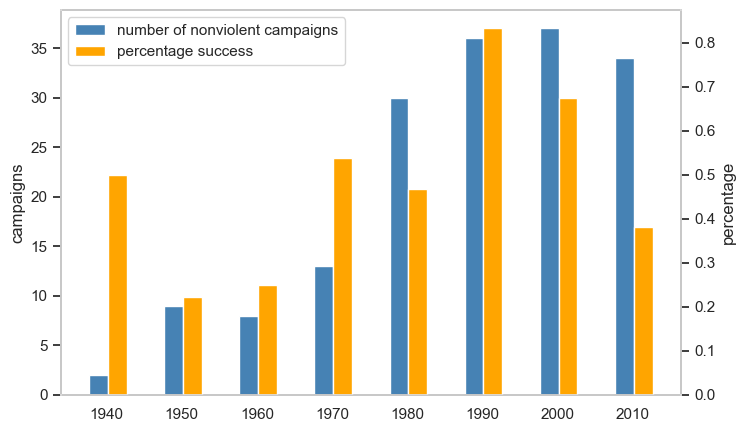

In [10]:
sns.set_style('white')
fig, ax_scampaigns = plt.subplots(figsize=(8, 5))
ax_srate = ax_scampaigns.twinx()

axes_lst = [ax_scampaigns, ax_srate]
colors = ['#4682B4', '#FFA500']

x = np.arange(len(nonviolent_table.index))
width = 0.25
multiplier = 0

x_label_offset = 0.11

for (attribute, measurement), ax, color, yaxis_label in zip(data.items(), axes_lst, colors, y_axis_labels):
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, color=color)
    multiplier += 1
    ax.set_xticks(x + x_label_offset, decades)
    ax.set_ylabel(yaxis_label)

ax_srate.spines[:].set_color('#DDDDDD')
handles_scampaigns, _ = ax_scampaigns.get_legend_handles_labels()
handles_srate, _ = ax_srate.get_legend_handles_labels()
_ = plt.legend(handles=handles_scampaigns+handles_srate, labels=labels)

In general we see a **rise in the nonviolent campaigns** (also mentioned in the previous plot). What we can also see is that from the 1950's up to the 1980's there is an *increase* in the success of the campaigns every decade. Then in the 80's the rise in nonviolent campaigns is **more than double** than in the 70's, but with a *slight drop in success*. The decade 1990-2000 seems to have been the period where **nonviolent campaigns were mostly successful with over 80% success rate**! This drops in the 2000's to around 65%, and in the 2010's it has fallen to *under 40%*! This looks concerning but there might be a *logical explanation*.

In [11]:
nonviol_2010_campaigns = campaign_frequencies.loc[(campaign_frequencies.decade == 2010) & (campaign_frequencies.NONVIOL == 1)]
nonviol_2010_campaigns.ONGOING.sum() / nonviol_2010_campaigns.shape[0]

0.14705882352941177

The NAVCO 1.2. dataset has data up until 2014. Obviously some of the campaigns at the time were **ongoing**, which means they are flagged as *not successful*. This can partially explain why the success rate in 2010's is much lower than the previous decades. The ongoing campaigns at the time were **about 15%**, meaning that the concluded campaigns' success rate is *actually higher*.

In [12]:
concluded_2010_nonv_camp = nonviol_2010_campaigns.loc[nonviol_2010_campaigns.ONGOING == 0]
concluded_2010_nonv_camp.SUCCESS.sum() / concluded_2010_nonv_camp.shape[0]

0.4482758620689655

The actual success rate is **around 45%**, still lower than the success rate of previous decades, but it is a more accurate depiction of how nonviolent campaigns have fared in this decade. As to what has led to such a drop is a matter of a *different and more thorough investigation*.

### Success Rate of Nonviolent and Violent Campaigns
We might have seen what's happening with the nonviolent campaigns, but let's compare if they are more successful than the violent ones.

In [13]:
violent = campaign_frequencies[campaign_frequencies['VIOL'] == 1]
violent_table = violent.groupby('decade', observed=False).agg(number_of_campaigns=('VIOL', 'sum'), successful_campaigns=('SUCCESS', 'sum'))
violent_table['success_rate'] = violent_table['successful_campaigns'] / violent_table['number_of_campaigns']

In [14]:
success_rates = pd.concat([nonviolent_table['success_rate'], violent_table['success_rate']], axis=1)
success_rates.columns = ['nonviolent', 'violent']

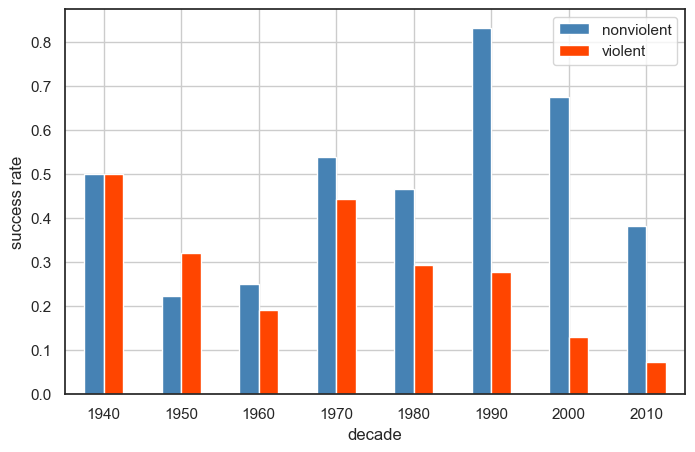

In [15]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.set_style('whitegrid')
colors = ['#4682B4', '#FF4500']
success_rates.plot.bar(ax=ax, color=colors)
ax.set_ylabel('success rate')
_ = ax.set_xticks(x, success_rates.index, rotation=0)

With this graph it is clear that from the 1960's **nonviolent campaigns are more successful**, and in some decades more than **2 or 3 times** than the violent campaigns. Therefore we can say that *nonviolent campaigns are more successful than violent campaigns in the modern era*!

## 2. Largest Resistance Campaigns, 1946-2014

Now let's take a look into the largest resistance campaigns. We will find the ones with **peak popular participation over 2%**. According to Chenoweth, peak popular participation refers to the *event that had the most participation* and not the cumulative number of people being part of the campaign throughout its duration.

In [16]:
pop_over_2_perc = navco[navco.PERCENTAGEPOPULARPARTICIPATION >= 0.02]
pop_over_2_perc = pop_over_2_perc.sort_values('PERCENTAGEPOPULARPARTICIPATION')

We'll create 2 new columns, one containing the campaign itself in the format of Location: Target, and the other one the result using the 3 binary columns.

In [17]:
columns = ['LOCATION', 'TARGET', 'PERCENTAGEPOPULARPARTICIPATION', 'SUCCESS', 'LIMITED', 'FAILURE']
campaigns = pop_over_2_perc.loc[:,columns]
campaigns['campaign'] = campaigns.LOCATION + ': ' + campaigns.TARGET

campaigns['result'] = ''
results = ['SUCCESS', 'LIMITED', 'FAILURE']
for result in results:
    campaigns['result'].where(campaigns[result] == 0, result.lower(), inplace=True)

Now let's replicate the resulting graph created by Chenoweth and examine it.

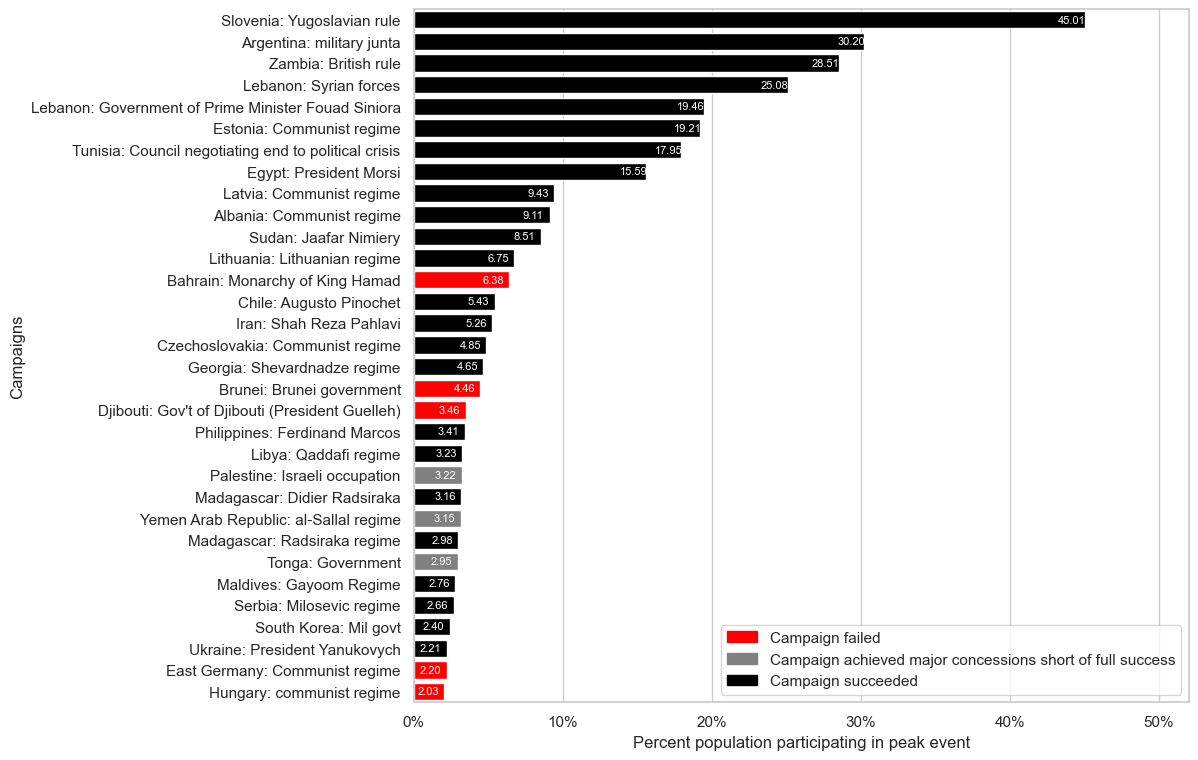

In [18]:
sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(10, 9))

color_dict = {'failure': 'red', 'limited': 'gray', 'success': 'black'}
ax.barh(y='campaign', width='PERCENTAGEPOPULARPARTICIPATION', data=campaigns, color=[color_dict[i] for i in campaigns['result']])

handles = [plt.Rectangle((0,0),1,1, color=color_dict[label]) for label in color_dict]
labels = ['Campaign failed', 'Campaign achieved major concessions short of full success', 'Campaign succeeded']
ax.yaxis.grid(False)
ax.set_xlabel('Percent population participating in peak event')
ax.set_ylabel('Campaigns')
ax.legend(handles, labels)

ax.set_xlim([0, 0.52])
ax.set_ylim(ax.get_ylim()[0] + 1.5, ax.get_ylim()[1] - 1.5)

for i, v in enumerate(campaigns['PERCENTAGEPOPULARPARTICIPATION']):
    ax.text(v-0.018, i, '{:.2f}'.format(v*100), color='white', ha='left', va='center', fontsize=8)
    
ax.xaxis.set_major_formatter('{:.0%}'.format)

The first thing to note here is that there are a **couple of cases breaking the 3.5% rule**, namely the campaigns against the Monarchy of King Hamad in Bahrain and against the Government in Brunei, with 6.38% and 4.46% peak popular participation respectively. In general, we can see that most of these campaigns have **succeeded** (75%) or **achieved major concessions** (9.38%), which starts indicating a *relationship* between **popular paricipation** and **success** in a campaign, still it's common sense.

### Greek Civil War and Polytechneio

Time to take a look in Greece and what campaigns the NAVCO dataset contains.

In [19]:
navco.loc[navco.LOCATION == 'Greece']

,NAVCOID,CAMPAIGN,LOCATION,BYEAR,EYEAR,TARGET,SUCCESS,LIMITED,FAILURE,ONGOING,...,OTHER,DURATION,PARTICIPATION,PERCENTAGEPOPULARPARTICIPATION,REGVIOL,DEFECT,VIOLENTFLANK,VIOLSIM,REGAID,STATESUP
119,401.0,Greek Civil War,Greece,1946.0,1949.0,British and US occupation,0.0,0.0,1.0,0.0,...,0.0,1778.0,40000.0,0.005092,1.0,0.0,NaN,0.0,1.0,1.0
120,89.0,Greek anti-military,Greece,1973.0,1974.0,Military rule,1.0,0.0,0.0,0.0,...,0.0,654.0,2500.0,0.000279,1.0,1.0,1.0,0.0,1.0,0.0


We can see 2 campaigns of civil resistance in Greece. The first one is the [Greek Civil War](https://en.wikipedia.org/wiki/Greek_Civil_War) which happened after WW2 from 1946 to 1949. After the war there was a referendum on whether Greece should retain its monarchy or not. The tensions were high and the DSE (Democratic Army of Greece) started deploying partisans in 1946 with the support of Yugoslavia and the USSR. Up until September 1947 the DSE were using guerilla tactics, when they decided to switch to conventional warfare. The monarchist government was backed by the British at first, and later by the USA that wanted to stop the spread of communism in Europe. The civil war ended in 1949, as the Soviet Union broke off their relations with Yugoslavia (1948), the Greek Communist Party sided with the USSR resulting in Yugoslavia closing its borders to the DSE. Then followed campaigns from the monarchists' side resulting in heavy casualties for the communists. In October 16 1949, a temporary ceasefire marked the end of the Greek Civil War, and therefore a failure for the insurgents.

After the civil war culminated, there still was the an anti-communist sentiment, backed by the Americans and the British. In the early 1960's, there began a [political instability](https://en.wikipedia.org/wiki/Greek_junta#Apostasia_and_political_instability), which was a result of continuous interference of then monarch Constantine II in governmental matters. In April 21 1967, there was a coup d'etat organized by greek military officers, which succeeded in getting control of the country and established a military junta. During 1973 the head of the government attempted a liberalization process, which didn't go that well, especially with some reforms demanding forcible conscription of university students. Then in [February 21st](https://en.wikipedia.org/wiki/Athens_Polytechnic_uprising#Background), students of the Law School of the National and Kapodistrian University of Athens (NKUA) went on a strike inside the buildings of the Law School, but the police suppressed them utlizing brutal methods. Few months later, in [November 14th](https://en.wikipedia.org/wiki/Athens_Polytechnic_uprising#November_events), students at the Athens Polytechnic went on a strike against the junta. In the early hours of November 17th, a tank sent by the junta broke down the front gate of the Polytechnic, resulting in many deaths and injuries. This temporarily supressed the anti-military movement, however a [chain of events](https://en.wikipedia.org/wiki/Greek_junta#Ioannidis_coup_and_regime), including a new army coup, a coup d'etat in Cyprus and the Turkish invasion of Cyprus, ultimately brought down the military rule and democracy was restored in July 1974, thus leading the campaign to a success.

## 3. The Effect of Participation on the Probability of Campaign Success


Time to see the effect of participaton in how successful a campaign is. We briefly discussed this while examining the largest in participation campaigns, but now we will investigate this in a more statistical way.

In [20]:
part_data = navco.loc[:, ['PARTICIPATION', 'PERCENTAGEPOPULARPARTICIPATION', 'SUCCESS']]

In order to calculate the participation per capita, we must check if we have missing data on participation. That's because we need the population, and in order to calculate it partipation must be > 0, since 0 divided by any non-zero or infinity number 0.

In [21]:
part_data.isna().sum()

PARTICIPATION                     9
PERCENTAGEPOPULARPARTICIPATION    0
SUCCESS                           0
dtype: int64

We will then calculate population as $$\frac{participation}{percentage\_popular\_participation}$$ and then the participation per capita as $$\frac{\ln(participation)}{\ln(population)}$$

In [22]:
part_data = part_data.dropna()
part_data['population'] = (part_data['PARTICIPATION'] / part_data['PERCENTAGEPOPULARPARTICIPATION']).astype(int)
part_data['participation_per_capita'] = np.log(part_data['PARTICIPATION']) / np.log(part_data['population'])

<Axes: xlabel='participation_per_capita', ylabel='SUCCESS'>

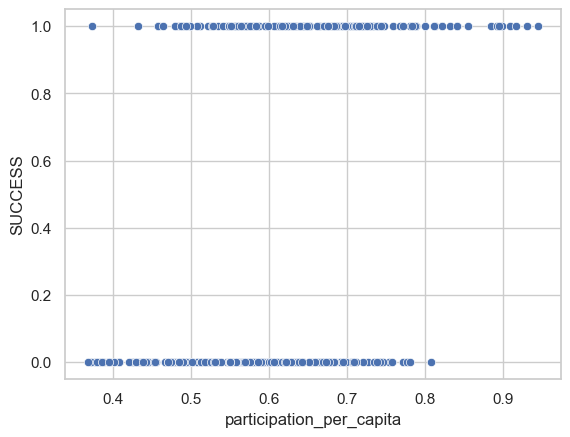

In [23]:
sns.scatterplot(data=part_data , x='participation_per_capita', y='SUCCESS')

At first glance we can see there **isn't a clear distinction** between the successful and the unsuccessful campaigns based only on participation per capita. Still not the statistical way, but a first view.

### A Logistic Regression Model with Participation Per Capita and Logged Population
Let's create our first logistic regression model for success with participation_per_capita and log(population).

In [24]:
success_model = logit('SUCCESS ~ participation_per_capita + np.log(population)', data=part_data).fit()

Optimization terminated successfully.
         Current function value: 0.580756
         Iterations 6


In [25]:
success_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
=======================================================================
Model:                Logit              Method:             MLE       
Dependent Variable:   SUCCESS            Pseudo R-squared:   0.130     
Date:                 2023-12-04 21:30   AIC:                447.3747  
No. Observations:     380                BIC:                459.1952  
Df Model:             2                  Log-Likelihood:     -220.69   
Df Residuals:         377                LL-Null:            -253.58   
Converged:            1.0000             LLR p-value:        5.1893e-15
No. Iterations:       6.0000             Scale:              1.0000    
-----------------------------------------------------------------------
                          Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-----------------------------------------------------------------------
Intercept                -2.8142   1.4961 -1.8811 0.0600 -5.7465 0.1180
participation_per_capita  7.6475   1.1664  6.5563 0.0000  5.3613 9.9336
np.log(population)       -0.1388   0.0736 -1.8871 0.0591 -0.2830 0.0054
=======================================================================

"""

We can see that both the intercept and the coefficient for log(population) are not statistically significant: p_value > 0.05.

In [26]:
preds = success_model.predict(part_data[['participation_per_capita', 'population']])

<Axes: xlabel='participation_per_capita'>

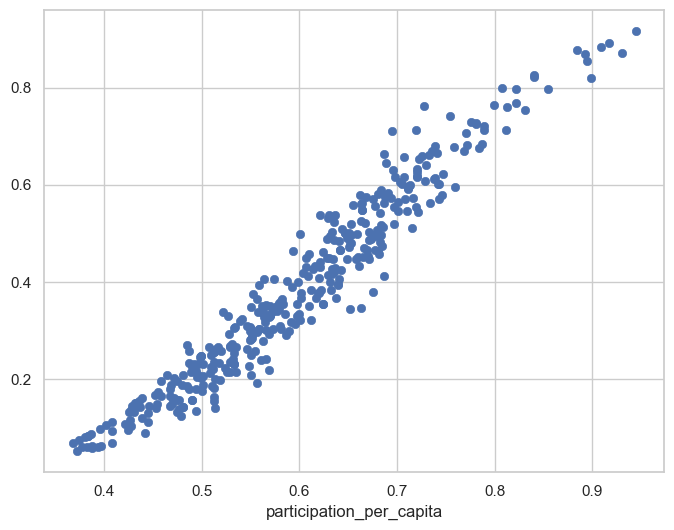

In [27]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=part_data['participation_per_capita'], y=preds, ax=ax, edgecolor=None)

Since we have two independent variable, it is easier to interpret this graph. We can see our plot trying to resemble a sigmoid curve. The logged population looks like giving some **variance** on the data that try to follow the hypothetical sigmoid. But as we mentioned above, the *logged population's coefficient isn't statistically significant*, therefore there is no need investigating it further. Let's take a look into participation per capita before we proceed to the second model.

This means that 1 unit increase in participation_per_capita increases the log-odds of a campaign succeeding by $7.6475$.

Since participation_per_capita has values from 0 to 1, it would make more sense to see the impact of 0.01 increase.

Equivantely, a 0.01 increase in participation per capita increases the log-odds by 0.0765, or the odds ratio increases by $e^{0.0765}\approx 8\%$.

In [28]:
success_model.params['participation_per_capita'], success_model.params['participation_per_capita'] / 100, round(np.exp(success_model.params['participation_per_capita']/100), 2)

(7.647473201355046, 0.07647473201355046, 1.08)

### Another Logistic Regression Model, but only with Participation Per Capita
Since in the previous model the logged population wasn't significant, we will run a new logistic regression just on participation per capita.

In [29]:
updated_success_model = logit('SUCCESS ~ participation_per_capita', data=part_data).fit()
updated_preds = updated_success_model.predict(part_data['participation_per_capita'])
updated_success_model.summary2()

Optimization terminated successfully.
         Current function value: 0.585556
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Results: Logit
========================================================================
Model:                 Logit              Method:             MLE       
Dependent Variable:    SUCCESS            Pseudo R-squared:   0.123     
Date:                  2023-12-04 21:30   AIC:                449.0222  
No. Observations:      380                BIC:                456.9026  
Df Model:              1                  Log-Likelihood:     -222.51   
Df Residuals:          378                LL-Null:            -253.58   
Converged:             1.0000             LLR p-value:        3.2041e-15
No. Iterations:        6.0000             Scale:              1.0000    
------------------------------------------------------------------------
                          Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------------
Intercept                -5.3469   0.7095 -7.5362 0.0000 -6.7375 -3.9563
participation_per_capita  8.0495   1.1414  7.0524 0.0000  5.8125 10.2866
========================================================================

"""

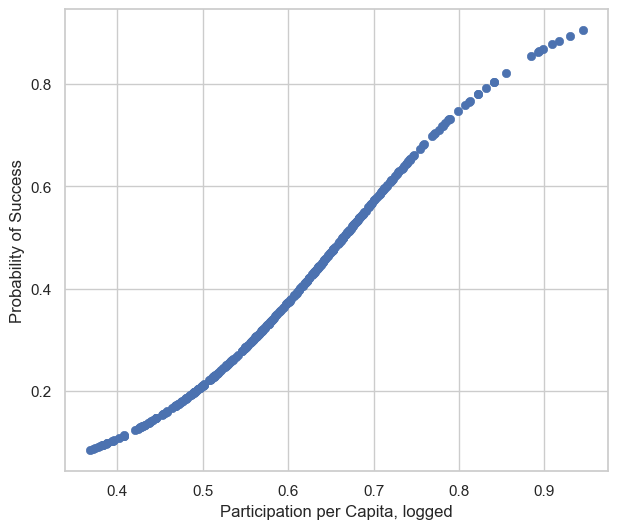

In [30]:
fig, ax = plt.subplots(figsize=(7, 6))
sns.scatterplot(x=part_data['participation_per_capita'], y=updated_preds, ax=ax, edgecolor=None)
ax.set_xlabel('Participation per Capita, logged')
_ = ax.set_ylabel('Probability of Success')

With this model, the situation is cleare. Since the model has only a single independent variable, namely participation_per_capita, the predictions are following a sigmoid curve. The difference between the two models, and consequently between the two plots, is that the models are ran on different set of variables. In the first, even though the coefficient for logged population isn't statistically significant, it still *has an impact* on the predictions as we saw earlier.

`participation_per_capita` is our sole independent variable, and it is statistically significant. Let's interpret it!

A 1 unit increase in participation_per_capita increases the log-odds of a campaign succeeding by $8.0495$.

Equivantely, a 0.01 increase in participation per capita increases the log-odds by 0.0805, or the odds ratio increases by $e^{0.0805}\approx 8\%$.

In [31]:
(updated_success_model.params['participation_per_capita'], 
updated_success_model.params['participation_per_capita'] / 100, 
round(np.exp(updated_success_model.params['participation_per_capita']/100), 2))

(8.04952003347903, 0.08049520033479031, 1.08)

## 4. The Level of Participation Tipping Point

### Debunking Chenoweth's 3.5% Rule
We will proceed to examining Chenoweth's 3.5% rule, which states that if peak popular participation is over 3.5% then a campaign will succeed. Is it true though?

Let's try recreating her table with the different bins containing the observations and the success rates. We will manually create these bins with a bit of Python code, and create a dictionary containing all the information we need. That's what the code below does:

In [32]:
bin_separators = (0.000035, 0.00015, 0.0006, 0.0025, 0.01, 0.035, 1)

observations_srate_dict = {
    'Peak Population Support (%)': ['less than 0.0035%', '0.0035% - 0.015%', '0.015% - 0.06%', '0.06% - 0.25%', '0.25% - 1.0%', '1.0% - 3.5%', 'greater than 3.5%'],
    'Observations': [],
    'Success Rate': []
}

for pos, val in enumerate(bin_separators):
    if pos == 0:
        cond = part_data.PERCENTAGEPOPULARPARTICIPATION < val
    else:
        previous_value = bin_separators[pos-1]
        cond = (previous_value <= part_data.PERCENTAGEPOPULARPARTICIPATION) & (part_data.PERCENTAGEPOPULARPARTICIPATION < val)
        
    temp = part_data.loc[cond]
    observations_srate_dict['Observations'].append(temp.shape[0])
    observations_srate_dict['Success Rate'].append(temp.SUCCESS.mean())

We will create a new dataframe containing our table, and then we will use tools pandas provides in order to present a more customised and stylished table, using the style accessor DataFrame objects have.

In [33]:
df_table = pd.DataFrame(observations_srate_dict)

This is a simple function that highlight cells in a specific color.

In [34]:
def highlight_cells(val, color):
    return 'background-color: {}'.format(color)

Some context into what's going on below. We start formatting our dataframe by giving a green color to the success rate, the more successful the campaigns of a bin are, the darker the green. After that we use blues to show how many observations there are in each bin, matching the colors of the table generally. The next color changes are done for aesthetic reasons only, without any further additional context. Lastly, we format success rate as a percentage with 2 decimal points for readability.

In [35]:
df_table.sort_index(ascending=False, inplace=True)
styled_table = df_table.style.background_gradient(
    cmap='Greens', 
    subset='Success Rate', 
    vmin=0, 
    vmax=1)
styled_table = styled_table.background_gradient(
    cmap='Blues',
    subset='Observations'
)
styled_table.applymap(highlight_cells, color='#d5e7ff', subset='Peak Population Support (%)')
styled_table = styled_table.format({'Success Rate':'{:.2%}'}).hide()
headers = {
    'selector': 'th:not(.index_name)',
    'props': 'background-color: #00419a; color: white; font-size: 1.3em;'
}
styled_table = styled_table.set_table_styles([headers])

In [36]:
styled_table

Peak Population Support (%),Observations,Success Rate
greater than 3.5%,18,88.89%
1.0% - 3.5%,41,60.98%
0.25% - 1.0%,92,45.65%
0.06% - 0.25%,95,45.26%
0.015% - 0.06%,66,24.24%
0.0035% - 0.015%,44,9.09%
less than 0.0035%,24,4.17%


According to [Chenoweth](https://carrcenter.hks.harvard.edu/files/cchr/files/CCDP_005.pdf), in 2013 she used the NAVCO 1.1 dataset she had created, containing *campaigns from 1900-2006*, where she saw that all campaigns with **popular support over 3.5%** were successful. However, a couple of issues occured. The first one was that a revolution in Brunei 1962 was **mistakenly excluded**, and the other case was an uprising against King Hamad in Bahrain in 2014 -**8 years after NAVCO 1.1 data**- both of which failed with peak popular participation > 3.5%. This is why we see the success rate being *88.89%*, since the dataset got **updated** and the **rule's number didn't**. She emphasizes a lot the fact that the 3.5% rule is not something that is always true, it is just a *general tendency*, since many other factors play a significant role in leading a campaign to success.

### Finding the Tipping Point with Statistics

But if the 3.5% rule is not true for all cases anymore, can we find the *tipping point for success*? That's what we'll answer now. Let's remind ourselves the model we created in the previous section.

In [37]:
updated_success_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Results: Logit
========================================================================
Model:                 Logit              Method:             MLE       
Dependent Variable:    SUCCESS            Pseudo R-squared:   0.123     
Date:                  2023-12-04 21:30   AIC:                449.0222  
No. Observations:      380                BIC:                456.9026  
Df Model:              1                  Log-Likelihood:     -222.51   
Df Residuals:          378                LL-Null:            -253.58   
Converged:             1.0000             LLR p-value:        3.2041e-15
No. Iterations:        6.0000             Scale:              1.0000    
------------------------------------------------------------------------
                          Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------------
Intercept                -5.3469   0.7095 -7.5362 0.0000 -6.7375 -3.9563
participation_per_capita  8.0495   1.1414  7.0524 0.0000  5.8125 10.2866
========================================================================

"""

Let's consider three cases: 

1. We use the coefficients the model found

2. We use the coefficients from the lowest end of the confidence interval

3. We use the coefficients from the highest end of the confidence interval

Then we will calculate the predictions using all these sets of coefficients. We already have the predictions for case 1, so let's put them to the dataframe and move on with the other 2.

In [38]:
part_data['predicted_success'] = updated_preds

In [39]:
x = part_data.participation_per_capita

Get the coefficients from both ends of the confidence interval.

In [40]:
inter_low, ppc_coeff_low = updated_success_model.conf_int()[0]
inter_high, ppc_coeff_high = updated_success_model.conf_int()[1]

We quickly define a function that calculates predictions based on given coefficients:

$$p(x) = \frac{1}{1 + e^{-(ax+b)}}$$

In [41]:
def p(x, a, b):
    return 1 / (1 + np.exp(-(a*x+b)))

In [42]:
part_data['low_predicted_success'] = p(x, ppc_coeff_low, inter_low)
part_data['high_predicted_success'] = p(x, ppc_coeff_high, inter_high)

We'll take a look to all 3 cases' predictions:

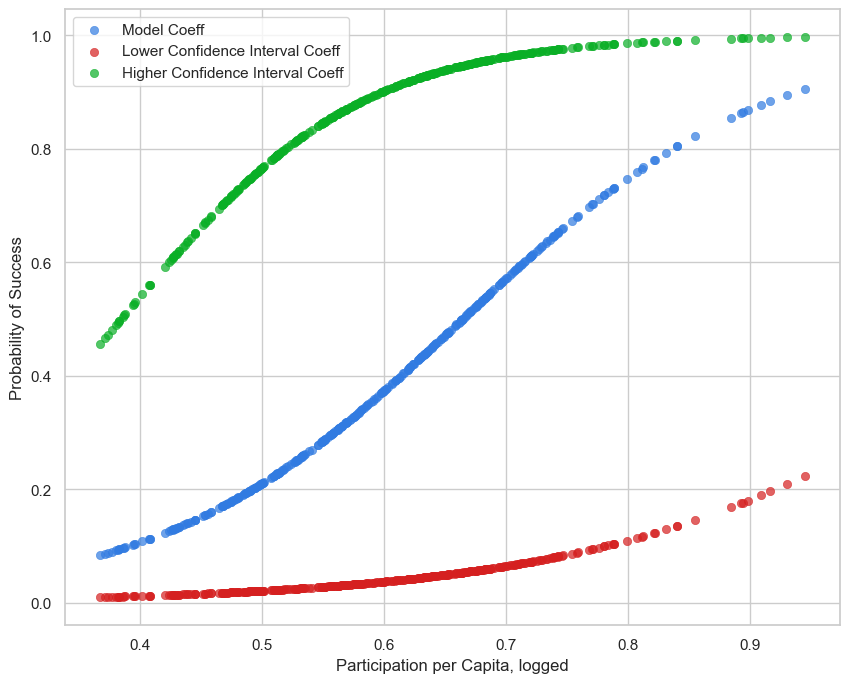

In [43]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=part_data, x='participation_per_capita', y='predicted_success', ax=ax, edgecolor=None, color='#317be1', alpha=0.7, label='Model Coeff')
sns.scatterplot(data=part_data, x='participation_per_capita', y='low_predicted_success', ax=ax, edgecolor=None, color='#d52020', alpha=0.7, label='Lower Confidence Interval Coeff')
sns.scatterplot(data=part_data, x='participation_per_capita', y='high_predicted_success', ax=ax, edgecolor=None, color='#0aaf26', alpha=0.7, label='Higher Confidence Interval Coeff')
ax.legend()
ax.set_xlabel('Participation per Capita, logged')
_ = ax.set_ylabel('Probability of Success')

Very interesting! Using the **higher end coefficients of the confidence interval**, we can actually see values that **reach 99%**! All we need to do is to actually find the percentage of peak participation and get the tipping point.

In [70]:
perc_99 = part_data.high_predicted_success >= 0.99
cols = ['PERCENTAGEPOPULARPARTICIPATION', 'participation_per_capita', 'high_predicted_success']
part_data.loc[perc_99, cols].sort_values('PERCENTAGEPOPULARPARTICIPATION').iloc[0].to_dict()

{'PERCENTAGEPOPULARPARTICIPATION': 0.0851063829787234,
 'participation_per_capita': 0.8548327207670052,
 'high_predicted_success': 0.9921316030210205}

From our data, we can derive that if **approximately 8.5%** of the population participates in a peak event of a campaign, then this will **succeed by 99%!

## 5. Nonviolent Resistance and Target Regime Type

The PolityV dataset has two different columns, polity and polity2 that show how autocratic or democratic is a country from a scale -10 to 10, where -10 is strongly autocratic whereas +10 is strongly democratic. If we take a look at their descriptions, polity2 fixes some issues with standardized authority scores (-66, -77, -88) to the conventional one (-10 to +10). We can use test both columns to check the statistical significance of the regime and discuss the results.

In [45]:
columns = ['LOCATION', 'EYEAR', 'SUCCESS', 'NONVIOL', 'PARTICIPATION', 'PERCENTAGEPOPULARPARTICIPATION']
campaigns = navco.loc[:, columns]
campaigns['population'] = campaigns['PARTICIPATION'] / campaigns['PERCENTAGEPOPULARPARTICIPATION']

In [46]:
def get_polity(country, endyear, polity2=False):
    cond = (polity5['country'] == country) & (polity5['year'] == endyear)
    if not polity2:
        return polity5.loc[cond, 'polity']
    else:
        return polity5.loc[cond, 'polity2']

There are a few things to consider before we get both polity scores. Some countries have different names in the datasets, for example South Korea is name Korea, South in polity5. Other ones are not independent, or they weren't at the time of campaign, for example Aruba, which is a country inside the Kingdom of Netherlands, and so there isn't any entry in polity5 about Aruba, which means we will get the Netherlands' scores.

In essence, we will use two dictionaries: the first one maps location and year to a polity5 country, and the second one maps location to polity5 country. For the non independent countries research has been conducted to assign the correct country (usually an oppressor). Unfortunately, Polity5 doesn't have data for Iceland, Maldives and Tonga, therefore they will be removed.

In [47]:
campaigns = campaigns.loc[~campaigns.LOCATION.isin(['Iceland', 'Maldives', 'Tonga'])]
campaigns.reset_index(drop=True, inplace=True)

In [48]:
country_year_mapper ={
    ('Angola', 1974.0): 'Portugal',
    ('Estonia', 1953.0): 'USSR',
    ('India', 1946.0): 'United Kingdom',
    ('Kenya', 1956.0): 'United Kingdom',
    ('Laos', 1949.0): 'France',
    ('Latvia', 1950.0): 'USSR',
    ('Lithuania', 1956.0): 'USSR',
    ('Madagascar', 1948.0): 'France',
    ('Malawi', 1959.0): 'United Kingdom',
    ('Nigeria', 1950.0): 'United Kingdom',
    ('Palestinian Territories', 1948.0): 'United Kingdom',
    ('Palestinian Territories', 2014.0): 'Israel',
    ('Russia', 1991.0): 'USSR',
    ('Sudan', 2012.0): 'Sudan-North',
    ('Sudan', 2013.0): 'Sudan-North',
    ('Sudan', 2014.0): 'Sudan-North',
    ('Tunisia', 1954.0): 'France',
    ('Vietnam', 1954.0): 'France',
    ('Vietnam', 1975.0): 'South Vietnam',
    ('Ukraine', 1990.0): 'USSR',
    ('Yemen', 1957.0): 'United Kingdom',
    ('Yemen', 1967.0): 'United Kingdom',
    ('Yemen', 1982.0): 'Yemen North',
    ('Zambia', 1963.0): 'United Kingdom',
    ('Zimbabwe', 1979.0): 'United Kingdom'
}

In [49]:
country_mapper = {'Aruba': 'Netherlands',
                  'Bosnia-Herzegovina': 'Bosnia',
                  'Brunei': 'United Kingdom',
                  'Burma/Myanmar': 'Myanmar (Burma)',
                  'Congo-Brazzaville (ROC)': 'Congo-Brazzaville',
                  'Cyprus': 'United Kingdom',
                  'Democratic Republic of Congo': 'Congo Kinshasa',
                  'East Germany': 'Germany East',
                  'East Timor': 'Indonesia',
                  'Eritrea': 'United Kingdom',
                  'Ghana': 'United Kingdom',
                  'Ivory Coast': "Cote D'Ivoire",
                  'Namibia': 'South Africa',
                  'Northern Ireland': 'United Kingdom',
                  'Palestine': 'Israel',
                  'Republic of the Congo': 'Congo-Brazzaville',
                  'Republic of Yemen': 'Yemen',
                  'Serbia': 'Yugoslavia',
                  'Slovakia': 'Czechoslovakia',
                  'South Korea': 'Korea South',
                  'Tibet': 'China',
                  'West Papua': 'Indonesia',
                  'Western Sahara': 'Morocco',
                  'Yemen Arab Republic': 'Yemen North',
                  "Yemen People's Republic": 'Yemen South',
                  'Zaire/DRC': 'Congo Kinshasa'
                  }

In [50]:
def map_navco_country_to_polity(country, year):
    return country_year_mapper.get(
        (country, year),
        country_mapper.get(
            country, country
        )
    )

In [51]:
polity_scores = {'polity': [],
                 'polity2': []}

for _, row in campaigns.iterrows():
    country = row['LOCATION']
    endyear = row['EYEAR']
    pol_country = map_navco_country_to_polity(country, endyear)
    pol = get_polity(pol_country, endyear)
    polity_scores['polity'].append(pol)
    pol2 = get_polity(pol_country, endyear, True)
    polity_scores['polity2'].append(pol2)

In [52]:
pol1 = pd.concat(polity_scores['polity'])
pol1.reset_index(drop=True, inplace=True)
pol2 = pd.concat(polity_scores['polity2'])
pol2.reset_index(drop=True, inplace=True)

In [53]:
campaigns['polity'] = pol1
campaigns['polity2'] = pol2

Now it's time to create our models. In the first one we will use the polity column while in the second one the polity2 column.

### Polity(1) Model

In [54]:
polity_model = logit('SUCCESS ~ NONVIOL + np.log(PARTICIPATION) + np.log(population) + polity', data=campaigns).fit()
polity_model.summary()

Optimization terminated successfully.
         Current function value: 0.552228
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                SUCCESS   No. Observations:                  376
Model:                          Logit   Df Residuals:                      371
Method:                           MLE   Df Model:                            4
Date:                Mon, 04 Dec 2023   Pseudo R-squ.:                  0.1718
Time:                        21:30:35   Log-Likelihood:                -207.64
converged:                       True   LL-Null:                       -250.70
Covariance Type:            nonrobust   LLR p-value:                 8.752e-18
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 2.1665      1.330      1.629      0.103      -0.440       4.773
NONVIOL                   0.9529      0.263      3.629      0.000       0.438       1.468
np.log(PARTICIPATION)     0.3582      0.078      4.615      0.000       0.206       0.510
np.log(population)       -0.4106      0.087     -4.721      0.000      -0.581      -0.240
polity                   -0.0083      0.004     -2.295      0.022      -0.015      -0.001
=========================================================================================
"""

To start off, the Intercept is not statistically significant, while the rest of our variables are. Pseudo-$R^2 = 0.171$, which is better than the models in Question 3, but still can't be considered a very good model.

* If NONVIOL = 1 (the campaign is nonviolent), then the log-odds of success increase by 0.9529

* Equivantely, the odds ratio increases by $e^{0.9529}\approx2.59$, or about 159%.

In [55]:
polity_model.params['NONVIOL'], round(np.exp(polity_model.params['NONVIOL']), 2)

(0.9529142486316774, 2.59)

* 1 unit increase in logged participation brings an increase of 0.3582 in the log-odds of a campaign succeeding.

* Equivantely, the odds ratio increases by $e^{0.3582}\approx1.43$, or about 43%.

In [56]:
polity_model.params['np.log(PARTICIPATION)'], round(np.exp(polity_model.params['np.log(PARTICIPATION)']), 2)

(0.3581513665654529, 1.43)

* 1 unit increase in logged population brings an decrease of 0.4106 in the log-odds of a campaign succeeding.

* Equivantely, the odds ratio decreases by $e^{-0.4106}\approx0.66$, or about 34%.

In [57]:
polity_model.params['np.log(population)'], round(np.exp(polity_model.params['np.log(population)']), 2)

(-0.41063095945099826, 0.66)

**Note**: Since we have seen the impact of participation per capita in a campaign succeeding, it is actually very logical why an increase in logged participation or a decrease in logged population bring an increase in the chances of success, since participation per capita is defined as logged participation over logged population, and we have seen that for increasing values of participation per capita, chances of success grow as well.

* 1 unit increase in polity, i.e. 1 step towards democratization, brings an decrease of 0.0083 in the log-odds of a campaign succeeding.

* Equivantely, the odds ratio decreases by $e^{-0.0083}\approx0.99$, or about 1%.

In [58]:
polity_model.params['polity'], round(np.exp(polity_model.params['polity']), 2)

(-0.008310567444532378, 0.99)

This is actually very weird. Someone could argue that in *more democratized countries* the chances of succeeding would be *higher* than in more authoritorian regimes. Well as we saw in the beginning of this section, the polity score has some values like -66, -77, and -88 which can **considerably affect** the model predictions, since the rest of the values are between or equal to -10 and 10. That's the reason why we'll run a model using the polity2 score as well.

### Polity2 Model

In [59]:
polity2_model = logit('SUCCESS ~ NONVIOL + np.log(PARTICIPATION) + np.log(population) + polity2', data=campaigns).fit()
polity2_model.summary()

Optimization terminated successfully.
         Current function value: 0.542996
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                SUCCESS   No. Observations:                  365
Model:                          Logit   Df Residuals:                      360
Method:                           MLE   Df Model:                            4
Date:                Mon, 04 Dec 2023   Pseudo R-squ.:                  0.1875
Time:                        21:30:35   Log-Likelihood:                -198.19
converged:                       True   LL-Null:                       -243.94
Covariance Type:            nonrobust   LLR p-value:                 6.370e-19
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 2.3591      1.338      1.763      0.078      -0.264       4.982
NONVIOL                   0.8720      0.271      3.215      0.001       0.340       1.403
np.log(PARTICIPATION)     0.3790      0.081      4.706      0.000       0.221       0.537
np.log(population)       -0.4246      0.088     -4.848      0.000      -0.596      -0.253
polity2                   0.0567      0.022      2.622      0.009       0.014       0.099
=========================================================================================
"""

To start off, the Intercept is once again not statistically significant, while the rest of our variables are. Pseudo-$R^2 = 0.1875$, which is better than the model we made previously with polity(1), but still can't be considered a very good model (< 0.2).

* If NONVIOL = 1 (the campaign is nonviolent), then the log-odds of success increase by 0.8719

* Equivantely, the odds ratio increases by $e^{0.8719}\approx2.39$, or about 139%.

If we compare this to the previous model's coefficient, the impact of the campaign being nonviolent has actually dropped by a small amount.

In [60]:
polity2_model.params['NONVIOL'], round(np.exp(polity2_model.params['NONVIOL']), 2)

(0.8719531606386297, 2.39)

* 1 unit increase in logged participation brings an increase of 0.3789 in the log-odds of a campaign succeeding.

* Equivantely, the odds ratio increases by $e^{0.3789}\approx1.46$, or about 46%.

Here we can see a small increase in the effect of logged participation in comparison to the previous model.

In [61]:
polity2_model.params['np.log(PARTICIPATION)'], round(np.exp(polity2_model.params['np.log(PARTICIPATION)']), 2)

(0.3789692172248081, 1.46)

* 1 unit increase in logged population brings an decrease of 0.4246 in the log-odds of a campaign succeeding.

* Equivantely, the odds ratio decreases by $e^{-0.4246}\approx0.65$, or about 35%.\

In absolute numbers, the effect of logged population in the chances of success have increased by little.

In [62]:
polity2_model.params['np.log(population)'], round(np.exp(polity2_model.params['np.log(population)']), 2)

(-0.4246333884716337, 0.65)

* 1 unit increase in polity, i.e. 1 step towards democratization, brings an increase of 0.0567 in the log-odds of a campaign succeeding.

* Equivantely, the odds ratio increases by $e^{0.0567}\approx1.06$, or about 6%.

This is were things are more interesting. In the previous model we saw a negative impact of the polity score as it was increasing, but here it is positive. Using the polity2 score makew more sense in the end, producing a more expected result, showing the impact of democracy in the chances of a campaign succeeding.

In [63]:
polity2_model.params['polity2'], round(np.exp(polity2_model.params['polity2']), 2)

(0.05672061803503836, 1.06)

In both models we saw that **NONVIOL remained significant** even with the *effect of the regime type*, on predicting the success of a campaign. However, let's also run a model where these two variables **interact**.

### Polity2 and NONVIOL interaction

In [64]:
inter_model = logit('SUCCESS ~ NONVIOL + np.log(PARTICIPATION) + np.log(population) + polity2 + NONVIOL:polity2', data=campaigns).fit()
inter_model.summary()

Optimization terminated successfully.
         Current function value: 0.532472
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                SUCCESS   No. Observations:                  365
Model:                          Logit   Df Residuals:                      359
Method:                           MLE   Df Model:                            5
Date:                Mon, 04 Dec 2023   Pseudo R-squ.:                  0.2033
Time:                        21:30:35   Log-Likelihood:                -194.35
converged:                       True   LL-Null:                       -243.94
Covariance Type:            nonrobust   LLR p-value:                 7.918e-20
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 2.2594      1.362      1.659      0.097      -0.410       4.929
NONVIOL                   0.8557      0.276      3.106      0.002       0.316       1.396
np.log(PARTICIPATION)     0.3480      0.082      4.253      0.000       0.188       0.508
np.log(population)       -0.4016      0.090     -4.479      0.000      -0.577      -0.226
polity2                   0.0026      0.029      0.089      0.929      -0.055       0.060
NONVIOL:polity2           0.1233      0.045      2.738      0.006       0.035       0.212
=========================================================================================
"""

The Intercept is once again not statistically significant, but neither is the **polity2 score**, while the rest of our variables are. Pseudo-$R^2 = 0.2033$, which is better than both previous models, and now it can be considered a *very good model* (> 0.2).

* If NONVIOL = 1 (the campaign is nonviolent), then the log-odds of success increase by 0.8556

* Equivantely, the odds ratio increases by $e^{0.8556}\approx2.35$, or about 135%.

In [65]:
inter_model.params['NONVIOL'], round(np.exp(inter_model.params['NONVIOL']), 2)

(0.8556936513568036, 2.35)

* 1 unit increase in logged participation brings an increase of 0.3479 in the log-odds of a campaign succeeding.

* Equivantely, the odds ratio increases by $e^{0.3479}\approx1.42$, or about 42%.

In [66]:
inter_model.params['np.log(PARTICIPATION)'], round(np.exp(inter_model.params['np.log(PARTICIPATION)']), 2)

(0.3479738383466905, 1.42)

* 1 unit increase in logged population brings an decrease of 0.4015 in the log-odds of a campaign succeeding.

* Equivantely, the odds ratio decreases by $e^{-0.4015}\approx0.67$, or about 33%.

In [67]:
inter_model.params['np.log(population)'], round(np.exp(inter_model.params['np.log(population)']), 2)

(-0.4015964290654879, 0.67)

* 1 unit increase in the interaction between polity and the campaign being nonviolent, brings an increase of 0.1233 in the log-odds of a campaign succeeding.

* Equivantely, the odds ratio increases by $e^{0.1233}\approx1.13$, or about 13%.

What does this even mean? Let's break it down: if a campaign **is nonviolent** and we gets an **increase in democratization**, then the effect is **much higher** than considering the polity score alone. This interaction, not only shows that *democracy on its own is not significant*, but combined with nonviolent campaigns and resistance movements can **actually have a larger positive impact**. Still, we can see that nonviolent campaigns are statistically significant, even if we consider the interaction between it and the regime type.

In [68]:
inter_model.params['NONVIOL:polity2'], round(np.exp(inter_model.params['NONVIOL:polity2']), 2)

(0.12332550064631186, 1.13)